<a href="https://colab.research.google.com/github/eminshall/QuantFinanceWorkbooks/blob/main/Black_Litterman_Portfolio_Allocation_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Wrangle

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [ ]:
#Create a Portfolio
symbols = [
    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'XOM',
    'UNH',
    'JNJ',
    'V',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'F',
    'MAR',
    'O',
    'HSY'
]

In [ ]:
#Get the stock data
portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")['Adj Close']

portfolio.head()

[*********************100%***********************]  20 of 20 completed


,AAPL,ABBV,AMZN,CAT,DIS,F,HD,HSY,JNJ,KO,LMT,MAR,META,MSFT,O,T,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.888065,77.285187,59.450500,138.114716,108.726059,9.871420,165.890121,100.043526,121.116432,38.548214,277.414917,128.663086,181.419998,80.738167,43.613770,18.731646,204.824707,105.182724,110.594681,64.879845
2018-01-03,40.880939,78.494591,60.209999,138.325729,109.192848,9.949394,166.754715,99.624123,122.273438,38.463558,279.740234,131.260422,184.669998,81.113930,43.498226,18.299082,206.973343,107.513130,111.695709,66.154091
2018-01-04,41.070831,78.046951,60.479500,140.225433,109.144234,10.120936,168.078064,100.320168,122.264725,39.005295,284.538879,130.539001,184.330002,81.827843,42.558495,18.469194,207.871750,108.210556,112.111000,66.245636
2018-01-05,41.538441,79.405579,61.457001,142.441742,108.551003,10.292476,169.833771,100.802063,123.273773,38.996830,287.116730,129.288406,186.850006,82.842346,42.527657,18.537237,211.835587,108.542252,114.795944,66.192245
2018-01-08,41.384163,78.133331,62.343498,146.021286,106.994987,10.253490,169.427933,101.783653,123.430367,38.937576,285.792969,131.154648,188.279999,82.926888,42.581600,18.590704,208.158844,109.860535,115.259529,66.489822


In [ ]:
#SP500 ETF Benchmark
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    245.828415
2018-01-03    247.383347
2018-01-04    248.426071
2018-01-05    250.081512
2018-01-08    250.538895
Name: Adj Close, dtype: float64

In [ ]:
#Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2550569369600,
 'MSFT': 2105686491136,
 'META': 555537924096,
 'AMZN': 1022629314560,
 'XOM': 472600051712,
 'UNH': 486265159680,
 'JNJ': 514836004864,
 'V': 477757865984,
 'HD': 297846505472,
 'ABBV': 286337564672,
 'KO': 270978416640,
 'DIS': 184242929664,
 'T': 141568163840,
 'UPS': 164951179264,
 'LMT': 125111361536,
 'CAT': 114442919936,
 'F': 51619483648,
 'MAR': 50664697856,
 'O': 40930299904,
 'HSY': 53085863936}

## Step 2: Getting Priors

In [ ]:
#Calculate Sigma and Delta to get implied market returns
#Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O?
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf() 

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.0907097939305745

<Axes: >

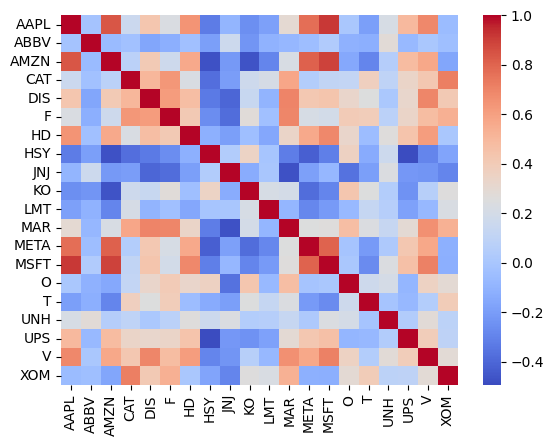

In [ ]:
#Visualize the Covariant Correlation 
sns.heatmap(S.corr(), cmap='coolwarm')

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.171971
ABBV    0.089075
AMZN    0.159851
CAT     0.112725
DIS     0.122036
F       0.125658
HD      0.123385
HSY     0.070870
JNJ     0.076969
KO      0.079578
LMT     0.083159
MAR     0.123966
META    0.173821
MSFT    0.163636
O       0.096500
T       0.080867
UNH     0.112712
UPS     0.108464
V       0.134188
XOM     0.101726
dtype: float64

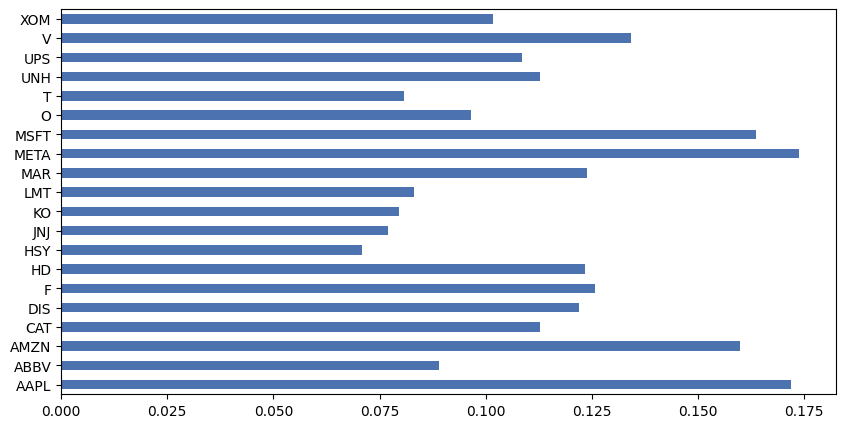

In [ ]:
#What am I looking at here?
market_prior.plot.barh(figsize=(10,5));

## Step 3: Integrating Views

In [ ]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'XOM':0.02,
    'UNH':0.01,
    'JNJ':0.15,
    'V':0.09,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'F':0.16,
    'MAR':-0.08,
    'O':0.30,
    'HSY':-0.26
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Creating Confidences

we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


# Step 4: Calculate Posterior Estimate Returns

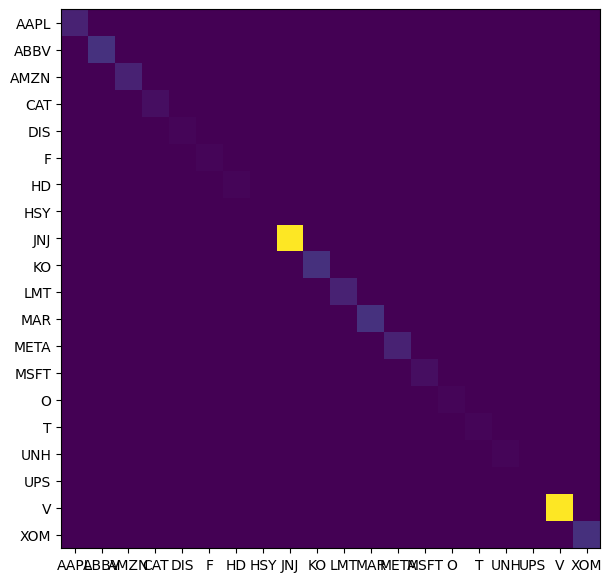

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.142965
ABBV    0.063369
AMZN    0.194535
CAT     0.186189
DIS     0.044942
F       0.128872
HD      0.095104
HSY     0.010442
JNJ     0.083702
KO      0.033074
LMT    -0.007835
MAR    -0.064690
META    0.135769
MSFT    0.139459
O       0.005057
T       0.061225
UNH     0.042891
UPS     0.101146
V       0.086460
XOM     0.043208
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.171971,0.142965,0.10
ABBV,0.089075,0.063369,0.07
AMZN,0.159851,0.194535,0.30
CAT,0.112725,0.186189,0.30
DIS,0.122036,0.044942,-0.23
F,0.125658,0.128872,0.16
HD,0.123385,0.095104,0.16
HSY,0.070870,0.010442,-0.26
JNJ,0.076969,0.083702,0.15
KO,0.079578,0.033074,0.01


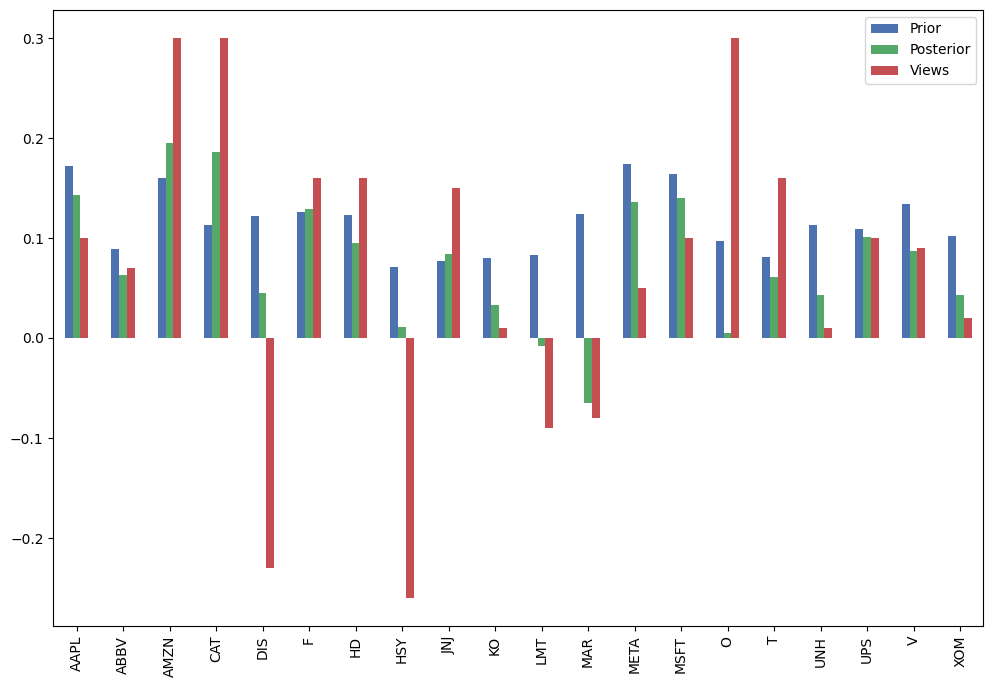

In [ ]:
rets_df.plot.bar(figsize=(12,8));

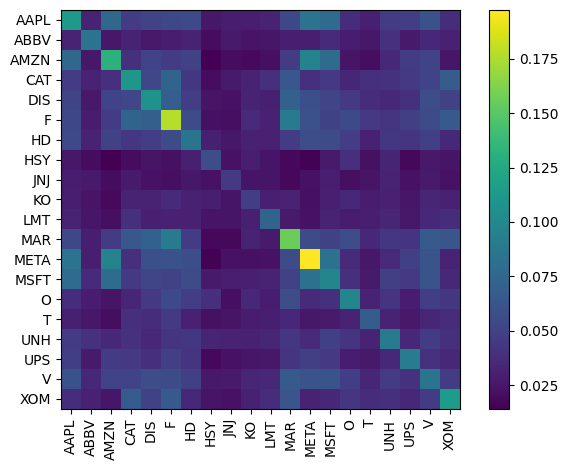

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Step 5: Portfolio Allocation

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.10507),
             ('ABBV', 0.02817),
             ('AMZN', 0.17301),
             ('CAT', 0.17361),
             ('DIS', 0.0),
             ('F', 0.08674),
             ('HD', 0.05366),
             ('HSY', 0.0),
             ('JNJ', 0.06189),
             ('KO', 0.0),
             ('LMT', 0.0),
             ('MAR', 0.0),
             ('META', 0.0855),
             ('MSFT', 0.10184),
             ('O', 0.0),
             ('T', 0.02597),
             ('UNH', 0.0),
             ('UPS', 0.06552),
             ('V', 0.03901),
             ('XOM', 0.0)])

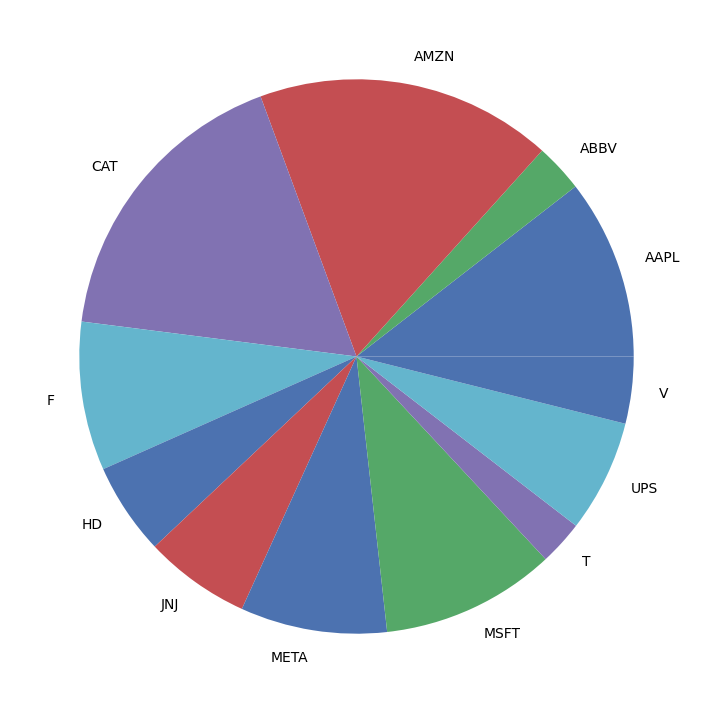

In [ ]:
pd.Series(weights).plot.pie(figsize=(9,9));

Expected annual return: 14.2%
Annual volatility: 24.0%
Sharpe Ratio: 0.51


/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:444: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.14165124232056592, 0.2401568701175918, 0.5065490829431608)

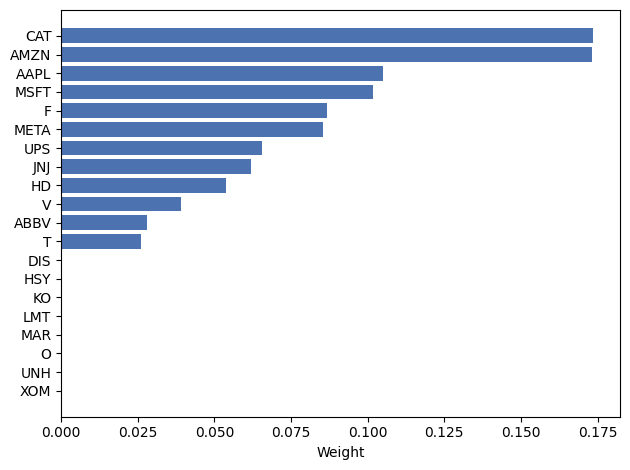

In [ ]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)